# Magnetic Bottle (Numpy): Introduction

In this notebook, we will use numpy and matplotlib to simulate the motion of a charged particle stuck in a "magentic bottle," a pair of magnetic dipoles whose fields can be used to trap charged particles. A magentic bottle is a simplified version of a device used to trap high-temperature plasma with magnetic fields (see https://en.wikipedia.org/wiki/Magnetic_mirror#Magnetic_bottles )

In [1]:
%matplotlib inline

First, we import our libraries: numpy and matplotlib. We also set some parameters for plots, to make them look pretty

In [2]:
import numpy
import matplotlib.pyplot as mpl

from numba import jit #This speeds up the simulation

In [3]:
# Parameters for plot attributes
mpl.rc("xtick", labelsize="large")
mpl.rc("ytick", labelsize="large")
mpl.rc("axes", labelsize="xx-large")
mpl.rc("axes", titlesize="xx-large")
mpl.rc("figure", figsize=(8,8))

Now, we define some key constants, like the mass of a proton, the charge of a proton, and the magnetic constant mu_naught

In [4]:
# define key constants
m_p = 1.67E-27       # mass of proton: kg
qe = 1.602E-19        # charge of proton: C
mu0 = numpy.pi * 4.0E-7 #mu_naught

To create the magnetic field, we will create two magnetic dipoles (note that current-carrying rings, which are actually used in magnetic bottles, approximate the magnetic field of a dipole). 

A magnetic dipole is defined by the magnetic dipole moment $\vec{\mu}$, and produces a field of the form:
$$ \vec{B}\left(\vec{r}\right) = \frac{\mu_0}{4\pi} \left( \frac{3\vec{r}(\vec{\mu}\cdot\vec{r})}{r^5} - \frac{\vec{\mu}}{r^3} \right).  $$

We will start by creating a magnetic dipole moment in the z-direction, strength 10,000. Then, we will create a function that calculates the magnetic field due to a magnetic dipole at a given position (x,y,z).

In [5]:
mu = 10000.0 * numpy.array([0.0, 0.0, 1.0]) # magnetic moment that points in the z direction

Now, we will create a function that calculates the field due to the magnetic bottle, based on the magnetic field function above.

In [6]:
# The jit command ensures fast execution using numba
@jit

def B_bot(x,y,z):
    zdisp = 10.0 #displacement of the two magnetic dipoles away from zero (one is at z = +zdisp, the other at -zdisp)
    
    # point dipole A
    posA = numpy.array([0.0, 0.0, zdisp]) #set the position of the first dipole
    rA = numpy.array([x,y,z]) - posA #find the difference between this position and the observation position
    rmagA = numpy.sqrt(sum(rA**2))
    B1A = 3.0*rA*numpy.dot(mu,rA) / (rmagA**5) #calculate the contribution of the first term to the magnetic field
    B2A = -1.0 * mu / (rmagA**3) #calculate the contribution of the second term
    
    # point dipole B
    posB = numpy.array([0.0, 0.0, -zdisp])
    rB = numpy.array([x,y,z]) - posB
    rmagB = numpy.sqrt(sum(rB**2))
    B1B = 3.0*rB*numpy.dot(mu,rB) / (rmagB**5)
    B2B = -1.0 * mu / (rmagB**3)
    
    return ((mu0/(4.0*numpy.pi)) * (B1A + B2A + B1B + B2B)) #return the magnetic field due to the magnetic bottle.

Having created this function, we can test it out by creating a graph of the resulting magnetic field in the x = 0 plane.

Text(0.5,1,"Magnetic Field of a 'Magnetic Bottle'")

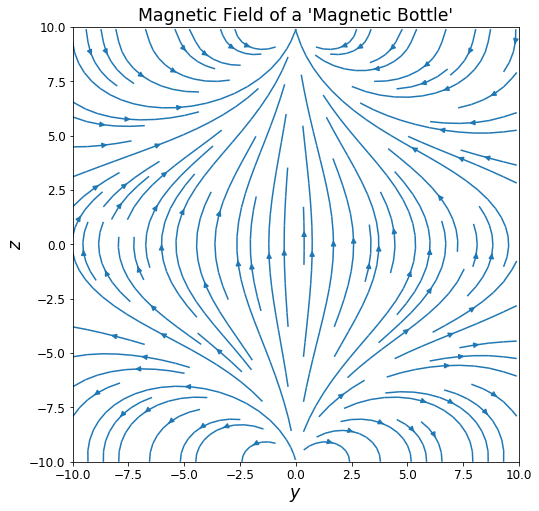

In [7]:
y = numpy.arange(-10.0, 10.0, .1) #create a grid of points from y = -10 to 10
z = numpy.arange(-10.0, 10.0, .1) #create a grid of points from z = -10 to 10
Y, Z = numpy.meshgrid(y,z) #turn this into a mesh
ilen, jlen = numpy.shape(Y) #define the length of the dimensions, for use in iteration
Bf = numpy.zeros((ilen,jlen,3)) #set the points to 0

for i in range(0, ilen): #iterate through the grid, setting each point equal to the magnetic field value there
    for j in range(0, jlen):
        Bf[i,j] = B_bot(0.0, Y[i,j], Z[i,j]) 
        
mpl.streamplot(Y,Z, Bf[:,:,1], Bf[:,:,2]) #plot the magnetic field
mpl.xlim(-10.0,10.0)
mpl.ylim(-10.0,10.0)
mpl.xlabel("$y$")
mpl.ylabel("$z$")
mpl.title("Magnetic Field of a 'Magnetic Bottle'")

Now, we will create a the simulated particle that will move through this magentic field. We will model it as an alpha particle, which has two protons and two neutrons (so, it has four times the mass of a proton but only twice the charge), giving it an initial velocity in the z-direction.

In [8]:
m = 4.0*m_p #mass of the alpha particle
q = 2.0*qe #charge of the alpha particle
QoverM = q/m

dt = 1E-5 #small timestep

t = numpy.arange(0.0, 1.0, dt) #create an array that will hold the times
rp = numpy.zeros((len(t), 3)) #create an array that will hold the position values
vp = numpy.zeros((len(t), 3)) #create an array that will hold the velocity values

v0 = 100.0 #set the initial velocity to 100 m/s
rp[0,:] = numpy.array([0.0, -5.0, 0.0]) #initialize the position to y=-5, 5m above the lower dipole
vp[0,:] = numpy.array([0.0, 0.0, v0]) #initialize the velocity to be in the z-direction

With all this setup, we can now simulate the motion of the particle by updating its position and velocity based on the magnetic force from the magnetic bottle function. We will add in a function that ends the loop if the particle has escaped and moved more than 20m from the origin. The particle's position and velocity values will be stored in an array for plotting.

In [9]:
for it in numpy.arange(0, len(t)-1,1):
    Bp = B_bot(rp[it,0], rp[it, 1], rp[it,2]) #input the current particle position into the B_bot function to get the magnetic field
    Ap = QoverM * numpy.cross(vp[it,:], Bp) #Calculate the magnetic force on the particle
    vp[it+1] = vp[it] + dt*Ap #Update the velocity of the particle based on this force
    rp[it+1] = rp[it] + dt*vp[it] #Update the positon of the particle based on this velocity
    if (numpy.sqrt(numpy.sum(rp[it+1]**2)) > 20.0): #If the particle escapes (goes more than 20m away from the origin) end the loop
        break

Now, we will make a plot of the particle's motion through the magnetic field: 

Text(0.5,1,"Trajectory of Alpha Particle in a 'Magnetic Bottle'")

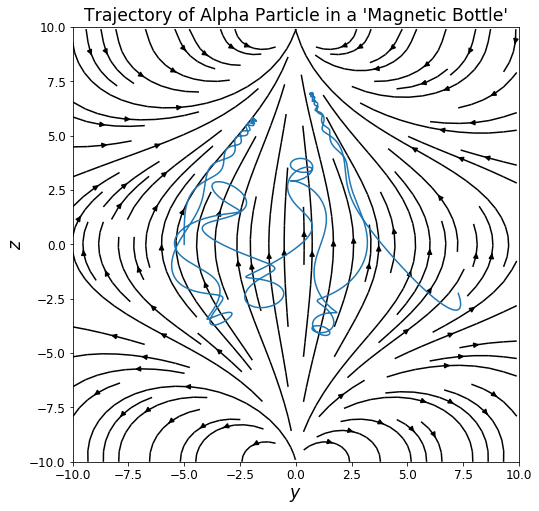

In [10]:
# now to make different views of the charged particle's trajectory
mpl.streamplot(Y,Z, Bf[:,:,1], Bf[:,:,2], color="black")
mpl.plot(rp[:,1], rp[:,2])
mpl.xlim(-10.0,10.0)
mpl.ylim(-10.0,10.0)
mpl.xlabel("$y$")
mpl.ylabel("$z$")
mpl.title("Trajectory of Alpha Particle in a 'Magnetic Bottle'")

## Additional questions you might investigate

1. Will a particle trapped inside a magnetic bottle ever escape? If so, under what conditions?
2. What magentic field and initial conditions do you need to trap particular types of particles? Are there optimal ring sizes or currents to trap certain particles?
3. A reversed magnetic bottle is known as a "bionic cusp" (https://en.wikipedia.org/wiki/Biconic_cusp). How does a particle's behavior in a bionic cusp differ from that in a magnetic bottle?

*(Note that these are just meant to be suggestions—feel free to investigate any question you find interesting!)*

## References

This program was based on an exercise developed by J.D. McDonnell for PICUP: 
J. D. McDonnell, "Motion of a Charged Particle in a Magnetic Field," Published in the PICUP Collection, July 2016.